In [1]:
import os
from collections import defaultdict
import statistics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tools.utils.settings import DefaultPath as defpath
from tools.utils.utils import get_mongodb_collections

In [2]:
test_name = 'bigtest'

In [3]:
small = True
mongoclient, collections = get_mongodb_collections(small)

In [4]:
test_dir = defpath.data_path.josie_tests + '/' + test_name
results_dir = test_dir + '/results/extracted'
images_tables_dir = test_dir + '/images_tables'

In [11]:
p = 10
algorithms = ['josie', 'lshforest']
modes = ['set', 'bag']

solvers = []
columns=[
    'query_id', 
    'result_id',
    'algorithm',
    'mode',
    'query_size',
    'max_table_overlap_size',
    'rank', 
    'algorithm_overlap', 
    'sloth_overlap', 
    'difference_overlap',
    'difference_overlap_norm'
    ]

results = pd.DataFrame(columns=columns)

for algorithm in algorithms:
    for mode in modes:
        fname = f"{results_dir}/a{algorithm}_m{mode}_k{p}_extracted.csv"

        if not os.path.exists(fname):
            continue

        solvers.append((algorithm, mode))
        results = pd.concat([results, pd.read_csv(fname)])

/tmp/ipykernel_78260/57617968.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.read_csv(fname)])


In [12]:
results

,query_id,result_id,algorithm,mode,query_size,max_table_overlap_size,rank,algorithm_overlap,sloth_overlap,difference_overlap,difference_overlap_norm
0,670597,556697,josie,set,85,105,1,55,42,13,0.123810
1,670597,2266995,josie,set,85,105,2,10,6,4,0.038095
2,670597,1452573,josie,set,85,105,3,9,6,3,0.028571
3,670597,1948443,josie,set,85,105,4,9,6,3,0.028571
4,670597,1530968,josie,set,85,105,5,9,6,3,0.028571
...,...,...,...,...,...,...,...,...,...,...,...
1799,1557345,1418484,lshforest,bag,31,35,5,24,10,14,0.400000
1800,1557345,1405493,lshforest,bag,31,35,6,26,10,16,0.457143
1801,1557345,1475417,lshforest,bag,31,35,7,25,10,15,0.428571
1802,1557345,1475801,lshforest,bag,31,35,8,21,10,11,0.314286


## Quanto sono validi i vari metodi? - Tasso di nullità

We define the Nullity Ratio the ratio for each query of retrivied IDs which actually have an overlap over a certain thresholds and the retrivied set size 

In [13]:
nullity_threshold = 0   # if the actual overlap between two tables isprint(next(resgroup)) under this threshold, the result is considered bad

x = []
for am, am_group in results.groupby(by=["algorithm", "mode"]):
    for query_id, q_group in am_group.groupby(by=["query_id"]):
        cnt = ((q_group['sloth_overlap'] <= nullity_threshold) & (q_group['difference_overlap'] <= nullity_threshold)).sum()
        num_query_results = q_group.count().values.tolist()[0]
        x.append([am[0], am[1], query_id[0], num_query_results, cnt, cnt / num_query_results])

x = pd.DataFrame(x, columns=['algorithm', 'mode', 'query_id', 'query_size', 'zero_overlap_cnt', 'zero_overlap_ratio'])

null_ratio_pivot = pd.pivot_table(x, values=['zero_overlap_ratio'], index=['algorithm', 'mode'], aggfunc=['mean', 'std', 'min', 'max'])
null_ratio_pivot

mean                std                min  \
               zero_overlap_ratio zero_overlap_ratio zero_overlap_ratio   
algorithm mode                                                            
josie     bag            0.000000           0.000000                0.0   
          set            0.000000           0.000000                0.0   
lshforest bag            0.001710           0.014023                0.0   
          set            0.007701           0.061225                0.0   

                              max  
               zero_overlap_ratio  
algorithm mode                     
josie     bag            0.000000  
          set            0.000000  
lshforest bag            0.125000  
          set            0.666667

## Algorithm vs True Overlap

In [25]:
data = [(am[0], am[1], group[(group['sloth_overlap'] != 0) & (group['difference_overlap'] != 0)]) for am, group in results.groupby(by=['algorithm', 'mode'])]

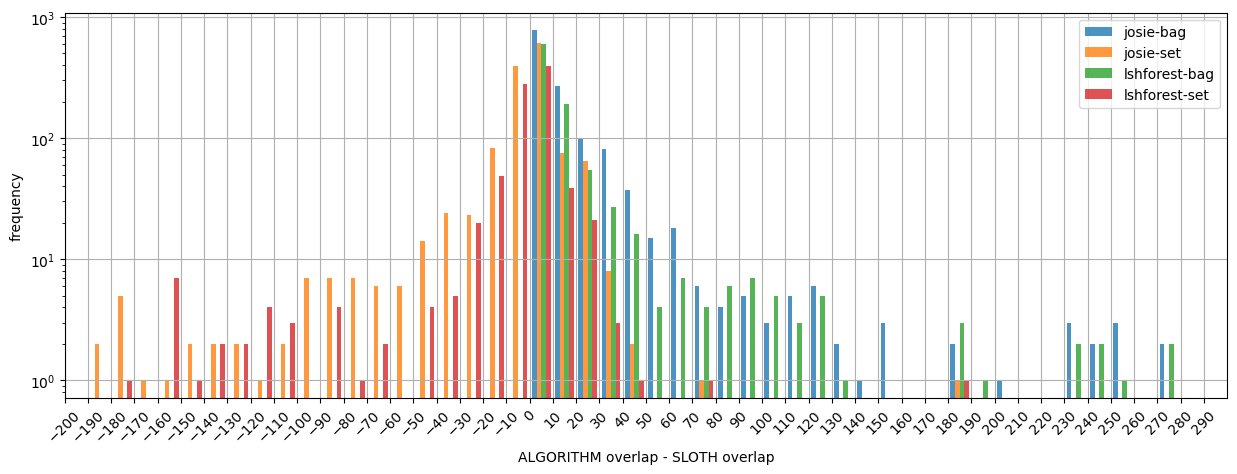

In [28]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(15, 5))
xmin, xmax, step = -200, 300, 10

ax.hist([d[2]['difference_overlap'] for d in data], 
         bins=np.arange(xmin, xmax, step), alpha=0.8, 
         label=[f'{a}-{m}' for a, m, _ in data],
         align='mid')
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax, step))
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)
ax.grid()
ax.set_xlabel('ALGORITHM overlap - SLOTH overlap')
ax.set_ylabel('frequency')

plt.legend()
plt.show()

In [46]:
results['boh'] = results['algorithm_overlap'] / (results['sloth_overlap'] + 1)

In [47]:
data = [(am[0], am[1], group[(group['sloth_overlap'] != 0) & (group['difference_overlap'] != 0)]) for am, group in results.groupby(by=['algorithm', 'mode'])]

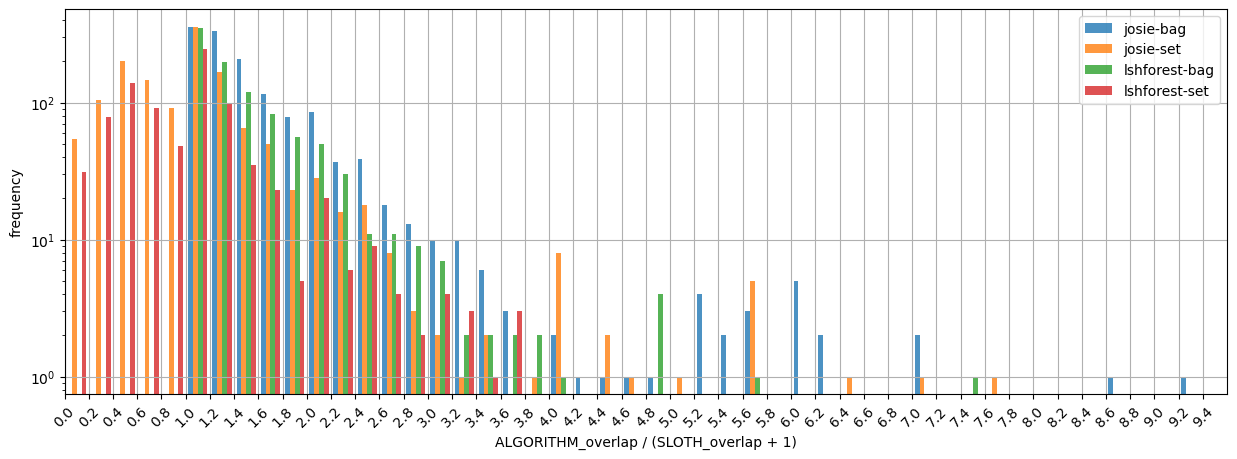

In [52]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(15, 5))
xmin, xmax, step = 0, 9.6, 0.2

ax.hist([d[2]['boh'] for d in data], 
         bins=np.arange(xmin, xmax, step), alpha=0.8, 
         label=[f'{a}-{m}' for a, m, _ in data],
         align='mid')
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax, step))
ax.grid()
ax.set_xlabel('ALGORITHM_overlap / (SLOTH_overlap + 1)')
ax.set_ylabel('frequency')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

## Creating Silver Standard

In [29]:
silver_standard = defaultdict(set)

results_ids = results.convert_dtypes().groupby(by='query_id')[['result_id', 'sloth_overlap']]

for query_id, ids_overlaps in results_ids:
    for i in ids_overlaps.values:
        _id, _overlap = i
        silver_standard[query_id].add((_id, _overlap))

for query_id in silver_standard.keys():
    silver_standard[query_id] = sorted(list(silver_standard[query_id]), key=lambda x: x[1], reverse=True)

## Precision at p - $P@p$
Corresponds to the number of relevant results among the top $p$ retrieved documents. Fails to take into account the positions of the relevant documents among the top $p$.Another shortcoming is that on a query with fewer relevant results than $p$, even a perfect system will have a score less than 1.


In [30]:
k_precisions = [1, 3, 5, 10]

precision_at_k_results = []

for query_id in silver_standard.keys():
    qss = [x[1] for x in silver_standard[query_id]]
    avg_overlap = round(statistics.mean(qss), 3)
    stdev_overlap = round(statistics.stdev(qss))

    for (algorithm, mode), data in results.groupby(by=["algorithm", "mode"]):
        ids = data[data['query_id'] == query_id]['result_id'].values.tolist()
        for k_precision in k_precisions:
            real_topk = [x[0] for x in silver_standard[query_id][:k_precision]]
            precision_at_k = set(real_topk).intersection(ids)
            
            precision_at_k_results.append([query_id, len(qss), avg_overlap, stdev_overlap, algorithm, mode, k_precision, len(precision_at_k)])

columns = [
    'query_id',
    'silver_std_size',
    'silver_std_ov_mean',
    'silver_std_ov_stdev',
    'algorithm',
    'mode',
    'k',
    'precision_at_k'
]

precision_at_k_results = pd.DataFrame(precision_at_k_results, columns=columns)
precision_at_k = precision_at_k_results.sort_values(by=['silver_std_size', 'query_id'], ascending=False)
# precision_at_k

In [31]:
patk_pivot = pd.pivot_table(precision_at_k, values=['precision_at_k'], index=['algorithm', 'mode'], columns=['k'], aggfunc=['mean', 'std', 'max'])
patk_pivot

mean                                          std  \
               precision_at_k                               precision_at_k   
k                          1         3         5         10             1    
algorithm mode                                                               
josie     bag        0.965517  2.738916  4.349754  7.655172       0.182917   
          set        0.798030  2.068966  3.177340  5.753695       0.402463   
lshforest bag        0.536946  1.103448  1.600985  2.817734       0.499866   
          set        0.482759  0.960591  1.344828  2.147783       0.500938   

                                                        max            
                                             precision_at_k            
k                     3         5         10             1  3  5   10  
algorithm mode                                                         
josie     bag   0.559183  0.980421  1.864018              1  3  5  10  
          set   1.031759  1.597671  2.726551              1  3  5  10  
lshforest bag   1.026451  1.429325  2.136732              1  3  5   9  
          set   0.953588  1.374920  2.098522              1  3  5   9

In [ ]:
for x in patk_pivot.index:
    print(x)

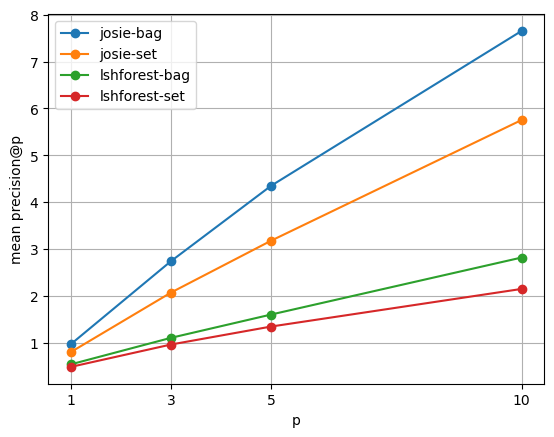

In [44]:
for row, label in zip(patk_pivot['mean', 'precision_at_k'].values, patk_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.xlabel('p')
plt.ylabel('mean precision@p')
plt.legend()
plt.grid()

## Normalized Discontinued Cumulative Gain - $nDCG@p$

Search result lists vary in length depending on the query. Comparing a search engine's performance from one query to the next cannot be consistently achieved using DCG alone, so the cumulative gain at each position for a chosen value of $ p $ should be normalized across queries. This is done by sorting all relevant documents in the corpus by their relative relevance, producing the maximum possible DCG through position $p$, also called Ideal DCG (IDCG) through that position. For a query, the normalized discounted cumulative gain, or nDCG, is computed as: 

$ nDCG_{p} = {DCG_{p} \over IDCG_{p}} $

where $ IDCG_{p} $ is the ideal discounted cumulative gain,

$ IDCG_{p} = \sum_{i=1}^{|REL_{p}|} {2^{rel_{i}} - 1 \over log_{2}(i + 1)}$

where $ REL_{p} $ represents the list of relevant documents (ordered by their relevance) in the corpus up to position $p$

In [36]:
from math import log2

def ndcg_at_p(true_relevances, scores, p):
    p = min(p, len(true_relevances), len(scores))
    if p <= 0: # because computing nDCG is meaningful only if there is more than one document 
        return 0, 1
    idcg = sum(rel / log2(i + 1) for i, rel in enumerate(true_relevances[:p], start=1))
    dcg = sum(rel / log2(i + 1) for i, rel in enumerate(scores[:p], start=1))
    if idcg < dcg:
        raise Exception()

    return dcg / idcg, p 

In [37]:
def get_nDCG_p(silver_standard:defaultdict[int:list[tuple[int,int]]], results:pd.DataFrame, *p):
    """ p values are assumed positive """
    ndcg_res = []
    for query_id in silver_standard:
        true_relevances = [x[1] for x in silver_standard[query_id]]
        max_silver_standard = true_relevances[0]

        for (algorithm, mode), data in results.groupby(by=['algorithm', 'mode']):
            r = data[data['query_id'] == query_id][['result_id', 'sloth_overlap']]
            result_relevances = [min(max_silver_standard, x[1]) for x in r.values.tolist()]
            for _p in p:
                ndcg, _actual_p = ndcg_at_p(true_relevances, result_relevances, _p)
                if query_id == 29938 and algorithm == 'josie' and mode == 'bag':
                    print(ndcg, _p, true_relevances[:_p], result_relevances[:_p])
                ndcg_res.append([query_id, len(true_relevances), algorithm, mode, _p, _p - _actual_p, ndcg])
    return ndcg_res

In [38]:
res = get_nDCG_p(silver_standard, results, 1, 3, 5, 10)

1.0 1 [36] [36]
1.0 3 [36, 30, 30] [36, 30, 30]
1.0 5 [36, 30, 30, 29, 29] [36, 30, 30, 29, 29]
1.0 10 [36, 30, 30, 29, 29, 29, 29, 29, 28, 28] [36, 30, 30, 29, 29, 29, 29, 29, 28, 28]


In [39]:
df = pd.DataFrame(res, columns=['query_id', 'silver_standard_size', 'algorithm', 'mode', 'p', 'missing_p', 'ndcg_p'])

In [40]:
silver_standard_size_threshold = 20
df = df[df['silver_standard_size'] >= silver_standard_size_threshold]

In [41]:
ndcg_pivot = df.pivot_table(index=['algorithm', 'mode'], columns=['p'], values=['ndcg_p', 'missing_p'], aggfunc=['mean', 'max']).convert_dtypes()
ndcg_pivot

mean                                                    \
               missing_p                                  ndcg_p             
p                     1         3         5         10        1         3    
algorithm mode                                                               
josie     bag          0       0.0       0.0       0.0  0.947038   0.95595   
          set          0       0.0       0.0       0.0  0.912608  0.891245   
lshforest bag          0       0.0  0.005525  1.049724  0.459255  0.516847   
          set          0  0.033149  0.116022  1.314917  0.413987  0.446782   

                                         max                           
                                   missing_p          ndcg_p           
p                     5         10        1  3  5  10     1  3  5  10  
algorithm mode                                                         
josie     bag   0.957503  0.966814         0  0  0  0      1  1  1  1  
          set   0.885061  0.879332         0  0  0  0      1  1  1  1  
lshforest bag   0.540462  0.592615         0  0  1  6      1  1  1  1  
          set   0.467481  0.498379         0  2  4  9      1  1  1  1

In [53]:
ndcg_pivot = df.pivot_table(index=['algorithm', 'mode'], columns=['p'], values=['ndcg_p'], aggfunc=['mean', 'max']).convert_dtypes()
ndcg_pivot

mean                                  max         
                  ndcg_p                               ndcg_p         
p                     1         3         5         10     1  3  5  10
algorithm mode                                                        
josie     bag   0.947038   0.95595  0.957503  0.966814      1  1  1  1
          set   0.912608  0.891245  0.885061  0.879332      1  1  1  1
lshforest bag   0.459255  0.516847  0.540462  0.592615      1  1  1  1
          set   0.413987  0.446782  0.467481  0.498379      1  1  1  1

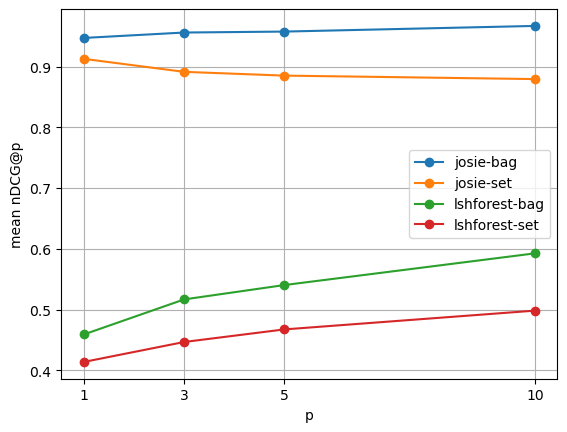

In [57]:
for row, label in zip(ndcg_pivot['mean', 'ndcg_p'].values, ndcg_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.legend()
plt.xlabel("p")
plt.ylabel("mean nDCG@p")
plt.grid()

In [ ]:
query_id = 29938
silver_standard[query_id]

In [ ]:
data = [(am[0], am[1], group[(group['sloth_overlap'] != 0) & (group['difference_overlap'] != 0)]) for am, group in results.groupby(by=['algorithm', 'mode'])]

In [ ]:
df = results[(results['algorithm'] == 'josie') & (results['mode'] == 'bag') & (results['query_id'] == query_id)]
df

In [ ]:
df